# Transfer learning with tensorflow part 1 : feature extraction

Levearing a working model to learn patterns for your own problem.
- Can leverage existing neural network architecture which is proven to work on similar problems on its own.


In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-03-06 08:11:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

t.zip.1              15%[==>                 ]  25.34M  3.27MB/s    eta 44s    ^C


In [2]:
import zipfile

zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zipref.extractall()
zipref.close()

In [3]:
import os

for dirpath, dirnames, filesNames in os.walk("data/10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filesNames)} images in {dirpath}")

There are 2 directories and 0 images in data/10_food_classes_10_percent
There are 10 directories and 0 images in data/10_food_classes_10_percent/test
There are 0 directories and 250 images in data/10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in data/10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in data/10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in data/10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in data/10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in data/10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in data/10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in data/10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in data/10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in data/10_fo

# Creating data loader (preparing data)
 using imagedatagenerator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "data/10_food_classes_10_percent/train"
test_dir = "data/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE, 
                                                         batch_size=BATCH_SIZE, class_mode="categorical")


test_data_10_percent = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE, 
                                                         batch_size=BATCH_SIZE, class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## setting up callbacks
- funtionality to the model during or after training.
Same examples:

- tracking using tensorboard callback.
- model checkpoint
- early stop callback to stop sooner


In [5]:
#  Create transorboard callback in a function

import datetime
import tensorflow as tf

def create_tensorboard_callback(experiment_name, dir_name="tensorboard"):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to: {log_dir}")
    return tensorboard_callback


## Creating model using tensorflow hub

In [6]:
import tensorflow_hub as hub


Important links

https://tfhub.dev

http://paperswithcode.com/

we are going to use https://tfhub.dev/google/efficientnet/b0/feature-vector/1 , its light and good.


and compare it to https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [7]:
efficient_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
def create_model(model_url, num_classes=10):
    """
    Takes tensorflow hub and create keras sequential model with it.
    """
    feautre_extraction_layer = hub.KerasLayer(model_url,trainable=False, # Freeze already learned patterns
                   name="feautre_extraction_layer",
                   input_shape=IMAGE_SHAPE+(3,)
                  )
    m = tf.keras.Sequential([
    feautre_extraction_layer,  
    tf.keras.layers.Dense(num_classes, activation='softmax',
                         name="output_layer")
    ])
    m.build([None, 224, 224, 3])  # Batch input shape.
    return m

In [10]:
resnet_model = create_model(resnet_url)

Metal device set to: Apple M1 Pro


2023-03-11 06:45:06.422022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-11 06:45:06.422564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
resnet_model.compile(loss='CategoricalCrossentropy',
               optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [41]:
resnet_history = resnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data_10_percent, 
                       validation_steps=len(test_data_10_percent), callbacks=[create_tensorboard_callback(dir_name="tensorboard_hub", experiment_name="resnet50v2")])

Saving Tensorboard log files to: tensorboard_hub/resnet50v2/20230307-074740
Epoch 1/5
24/24 [==============================] - 15s 547ms/step - loss: 0.1406 - accuracy: 0.9893 - val_loss: 0.6309 - val_accuracy: 0.7892
Epoch 2/5
24/24 [==============================] - 13s 544ms/step - loss: 0.1228 - accuracy: 0.9920 - val_loss: 0.6219 - val_accuracy: 0.7936
Epoch 3/5
24/24 [==============================] - 13s 540ms/step - loss: 0.1070 - accuracy: 0.9920 - val_loss: 0.6217 - val_accuracy: 0.7932
Epoch 4/5
24/24 [==============================] - 13s 541ms/step - loss: 0.0958 - accuracy: 0.9947 - val_loss: 0.6199 - val_accuracy: 0.7912
Epoch 5/5
24/24 [==============================] - 13s 541ms/step - loss: 0.0873 - accuracy: 0.9973 - val_loss: 0.6234 - val_accuracy: 0.7936


In [37]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feautre_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="validation_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="validation_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

plot_loss_curves(resnet_history)

NameError: name 'resnet_history' is not defined

In [ ]:
import pathlib
import numpy as np

data_dir = pathlib.Path("data/10_food_classes_10_percent/test")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))



In [12]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    
    img = tf.image.decode_image(img)
    
    img = tf.image.resize(img, size=[img_shape, img_shape])
    
    img = img/255.
    return img

def pred_and_plot(model, filename, class_names=class_names):
    img = load_and_prep_image(filename)
    result = model.predict(tf.expand_dims(img, axis=0))

    if len(result[0])>1:
        pred_class=class_names[tf.argmax(result[0])]
    else:
        pred_class = class_names[int(tf.round(result))]
    
    plt.imshow(img)
    plt.title(pred_class)
    plt.axis(False)
    plt.figure()
pred_and_plot(resnet_model, "03-pizza-dad.jpeg", class_names)
pred_and_plot(resnet_model, "03-steak.jpeg", class_names)
pred_and_plot(resnet_model, "03-sushi.jpeg", class_names)
pred_and_plot(resnet_model, "03-hamburger.jpeg", class_names)


NameError: name 'class_names' is not defined

In [43]:
efficient_model = create_model(efficient_url)

2023-03-07 07:51:20.390090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-07 07:51:20.606967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [44]:
efficient_model.compile(loss='CategoricalCrossentropy',
               optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [46]:
efficient_history = efficient_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data_10_percent, 
                       validation_steps=len(test_data_10_percent), callbacks=[create_tensorboard_callback(dir_name="tensorboard_hub", experiment_name="efficientb0")])

Saving Tensorboard log files to: tensorboard_hub/efficientb0/20230307-075202
Epoch 1/5


2023-03-07 07:52:03.534043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 1.8568 - accuracy: 0.4333

2023-03-07 07:52:11.483845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 17s 494ms/step - loss: 1.8568 - accuracy: 0.4333 - val_loss: 1.2986 - val_accuracy: 0.7460
Epoch 2/5
24/24 [==============================] - 9s 380ms/step - loss: 1.0698 - accuracy: 0.7813 - val_loss: 0.8662 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 9s 368ms/step - loss: 0.7656 - accuracy: 0.8360 - val_loss: 0.6967 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 8s 358ms/step - loss: 0.6130 - accuracy: 0.8587 - val_loss: 0.6105 - val_accuracy: 0.8616
Epoch 5/5
24/24 [==============================] - 8s 360ms/step - loss: 0.5167 - accuracy: 0.8880 - val_loss: 0.5553 - val_accuracy: 0.8636


In [45]:
efficient_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feautre_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


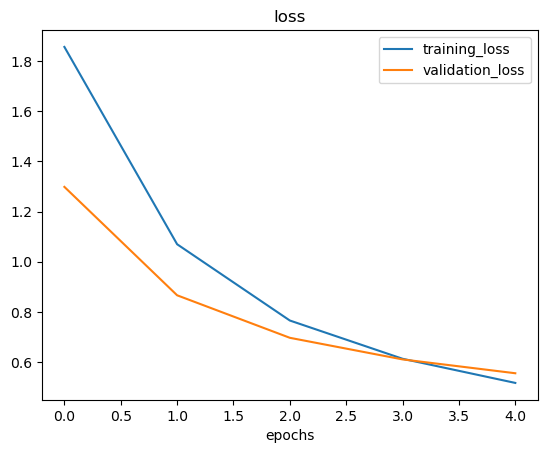

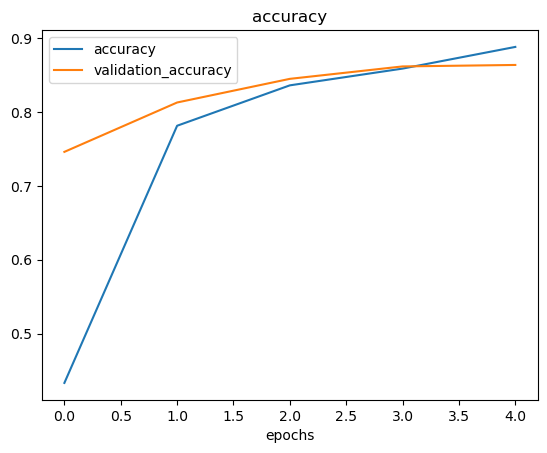

In [48]:
plot_loss_curves(efficient_history)


1/1 [==============================] - 0s 30ms/step


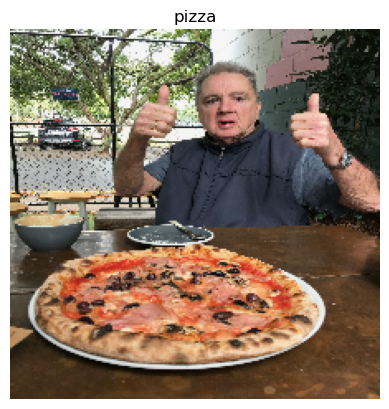

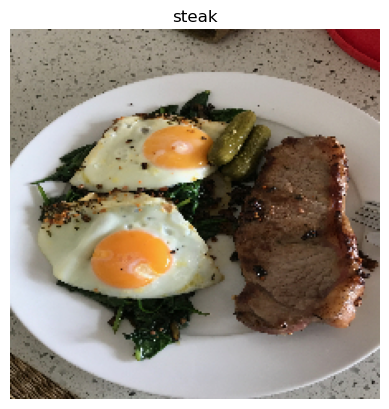

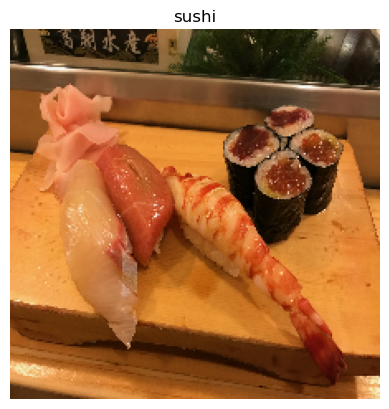

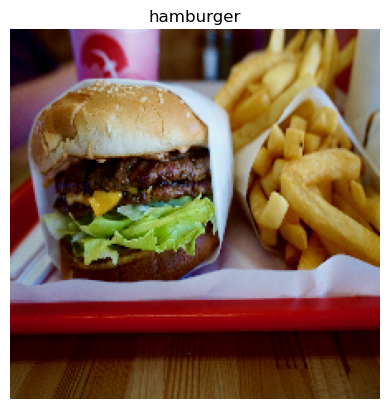

<Figure size 640x480 with 0 Axes>

In [49]:
pred_and_plot(efficient_model, "03-pizza-dad.jpeg", class_names)
pred_and_plot(efficient_model, "03-steak.jpeg", class_names)
pred_and_plot(efficient_model, "03-sushi.jpeg", class_names)
pred_and_plot(efficient_model, "03-hamburger.jpeg", class_names)

Types of transfer learning

- "As is", use model as is
- feature extraction : use pretrained model and adjut output your example (1000 classes to 10 classes)
- fine tuning - take pre trained model and fine tune all layers for your need

# Tensorboard usage


In [17]:
!tensorboard dev upload --logdir ./tensorboard_hub --name "Efficientnetb0 vs resnet50v2"    --description "Compare for 10% food images set" --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard_hub

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) ^C
Traceback (most recent call last):
  File "/Users/sanjeevhalyal/.conda/envs/MachineLearning-3.8/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/Users/sanjeevhalyal/.conda/envs/MachineLearning-3.8/lib/python3.8/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/Users/sanjeevhalyal